In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.stats import multivariate_normal as mvn

import vsem_jax as vsem
from vsem_inv_prob import InvProb, VSEMPrior, VSEMLikelihood

import sys
sys.path.append("./../linear_Gaussian/")
from Gaussian import Gaussian

rng = np.random.default_rng(6435)


# Exact Inverse Problem

In [3]:
n_days = 365 * 2
par_names = ["kext", "av"]

likelihood = VSEMLikelihood(rng, n_days, par_names)
prior = VSEMPrior(likelihood.par_names, rng)
inv_prob = InvProb(rng, prior, likelihood)

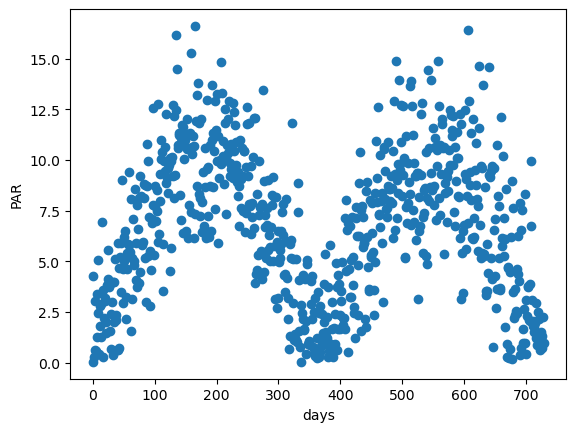

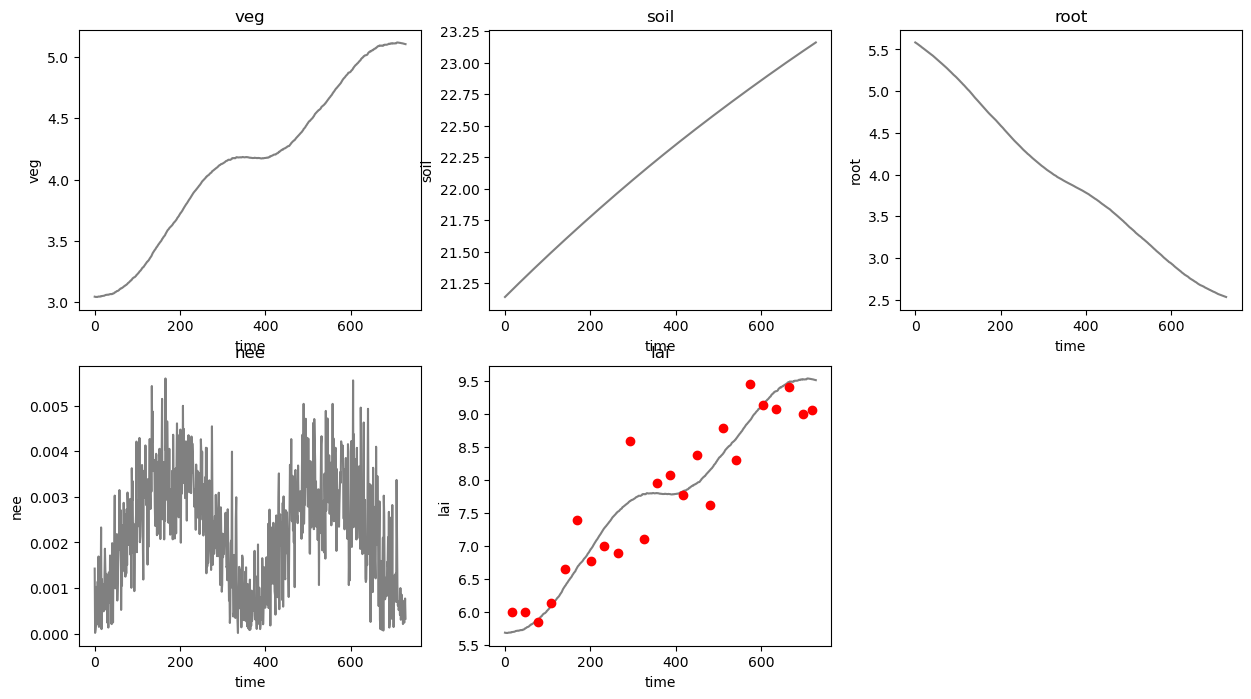

In [4]:
likelihood.plot_driver()
likelihood.plot_ground_truth()

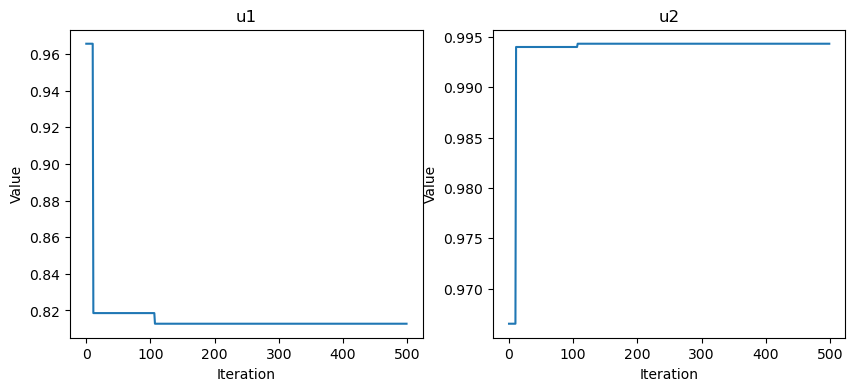

In [10]:
inv_prob.reset_sampler()
proposal_cov = np.diag([0.1**2, 0.1**2])
samp, trace_plot = inv_prob.sample_posterior(n_step=1000)

display(trace_plot)

In [11]:
u1_supp = prior.dists[par_names[0]].support()
u2_supp = prior.dists[par_names[1]].support()
u1_grid = np.linspace(u1_supp[0], u1_supp[1], 100)
u2_grid = np.linspace(u2_supp[0], u2_supp[1], 100)
U1_grid, U2_grid = np.meshgrid(u1_grid, u2_grid)

log_post_pdf = lambda u1, u2: inv_prob.log_posterior_density(np.array([u1, u2]))
log_post_grid = np.vectorize(log_post_pdf)(U1_grid, U2_grid)

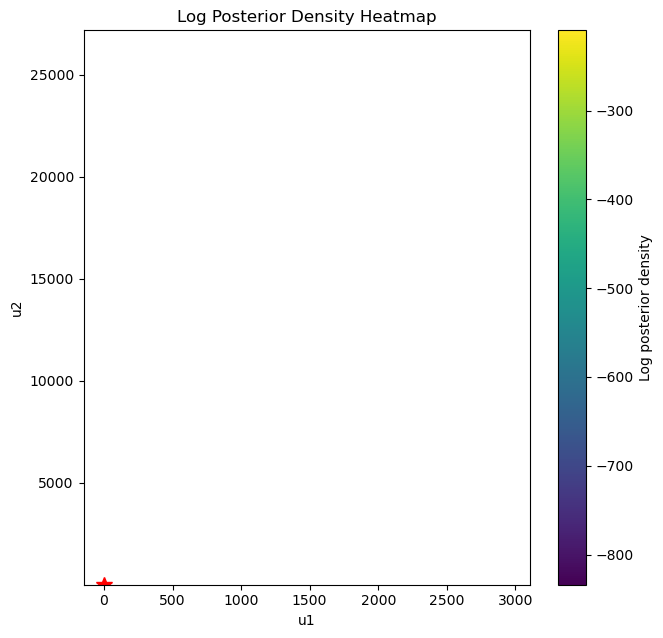

In [12]:
plt.figure(figsize=(7.2, 7.2))
pcm = plt.pcolormesh(U1_grid, U2_grid, log_post_grid, shading='auto', cmap='viridis')
plt.plot(*likelihood.par_true, "*", color="red", markersize=12)
plt.title("Log Posterior Density Heatmap")
plt.xlabel("u1")
plt.ylabel("u2")
plt.colorbar(pcm, label="Log posterior density")
plt.show()

# GP Surrogate Model

In [7]:
# Initial design for emulator
# Enable Float64 for more stable matrix inversions.
from jax import config
import jax.numpy as jnp
import jax.random as jr
import gpjax as gpx
import matplotlib as mpl
import matplotlib.pyplot as plt

config.update("jax_enable_x64", True)
key = jr.key(123)

/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
n = 20
x = jnp.asarray(prior.sample(n))
y = jnp.asarray(inv_prob.log_posterior_density(x)).reshape((-1,1))

design = gpx.Dataset(X=x, y=y)

In [39]:
# Prior Kernels
lengthscales = jnp.array([1., 1.])
scale = 1.0

kernel = gpx.kernels.RBF(lengthscale=lengthscales, variance=scale**2)

In [40]:
# Mean Function
constant_param = gpx.parameters.Parameter(value=design.y.mean(), tag='None')
meanf = gpx.mean_functions.Constant(constant_param)

In [41]:
# Prior GP
gp_prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)

In [42]:
gp_likelihood = gpx.likelihoods.Gaussian(num_datapoints=design.n)
gp_posterior = gp_prior * gp_likelihood

In [43]:
gp_posterior

ConjugatePosterior( # NonNegativeReal: 2 (16 B), PositiveReal: 2 (16 B), Parameter: 1 (8 B), Total: 5 (40 B)
  prior=Prior( # PositiveReal: 2 (16 B), NonNegativeReal: 1 (8 B), Parameter: 1 (8 B), Total: 4 (32 B)
    kernel=RBF( # PositiveReal: 2 (16 B), NonNegativeReal: 1 (8 B), Total: 3 (24 B)
      active_dims=slice(None, None, None),
      n_dims=2,
      compute_engine=<gpjax.kernels.computations.dense.DenseKernelComputation object at 0x16a419220>,
      lengthscale=PositiveReal( # 2 (16 B)
        value=Array(shape=(2,), dtype=dtype('float64')),
        tag="'positive'"
      ),
      variance=NonNegativeReal( # 1 (8 B)
        value=Array(1., dtype=float64, weak_type=True),
        tag="'non_negative'"
      )
    ),
    mean_function=Constant( # Parameter: 1 (8 B)
      constant=Parameter( # 1 (8 B)
        value=Array(-168.7609593, dtype=float64),
        tag="'None'"
      )
    ),
    jitter=1e-06
  ),
  likelihood=Gaussian( # NonNegativeReal: 1 (8 B)
    obs_stddev=NonNegati

In [44]:
print("Starting mll: ", -gpx.objectives.conjugate_mll(gp_posterior, design))

gp_opt_posterior, history = gpx.fit_scipy(
    model=gp_posterior,
    objective=lambda p, d: -gpx.objectives.conjugate_mll(p, d),
    train_data=design,
    trainable=gpx.parameters.Parameter,
)

print("Ending mll: ", -gpx.objectives.conjugate_mll(gp_opt_posterior, design))

Starting mll:  225334.2408843735


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/scipy/optimize/_minimize.py:780: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 130.221634
         Iterations: 76
         Function evaluations: 170
         Gradient evaluations: 164
Ending mll:  130.2216338389817


In [51]:
# Test points
n_test = 50. ** 2
n_test_1d = int(jnp.sqrt(n_test))

u1_supp = prior.dists[prior._par_names[0]].support()
u2_supp = prior.dists[prior._par_names[0]].support()
u1 = jnp.linspace(u1_supp[0], u1_supp[1], n_test_1d)
u2 = jnp.linspace(u2_supp[0], u2_supp[1], n_test_1d)
U1, U2 = jnp.meshgrid(u1, u2, indexing='ij')
x_test = jnp.stack([U1.ravel(), U2.ravel()], axis=1)

In [55]:
# GP predictions
latent_dist = gp_opt_posterior.predict(x_test, train_data=design)
predictive_dist = gp_opt_posterior.likelihood(latent_dist)

predictive_mean = predictive_dist.mean
predictive_std = jnp.sqrt(predictive_dist.variance)

In [63]:
predictive_mean

Array([-1612.78398055, -1612.78398402, -1612.78398735, ...,
       -1612.78398568, -1612.78398227, -1612.78397871], dtype=float64)

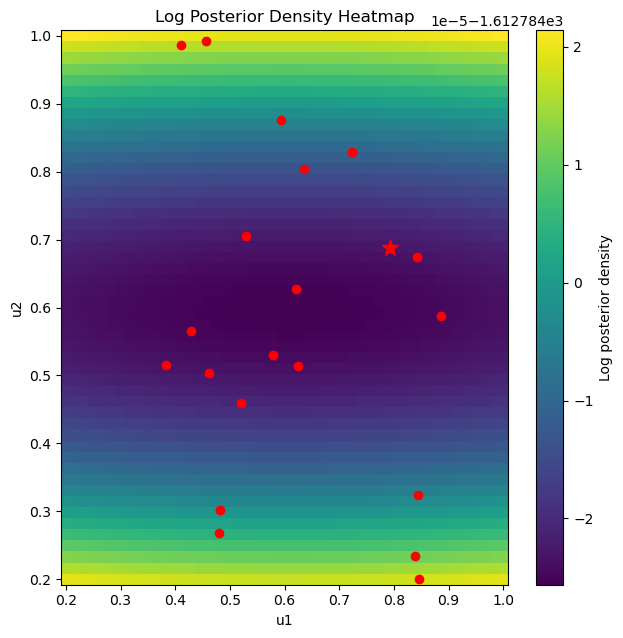

In [62]:
plt.figure(figsize=(7.2, 7.2))
pcm = plt.pcolormesh(U1, U2, predictive_mean.reshape(n_test_1d, n_test_1d), shading='auto', cmap='viridis')
plt.plot(design.X[:,0], design.X[:,1], "o", color="red")
plt.plot(*likelihood.par_true, "*", color="red", markersize=12)
plt.title("Log Posterior Density Heatmap")
plt.xlabel("u1")
plt.ylabel("u2")
plt.colorbar(pcm, label="Log posterior density")
plt.show()

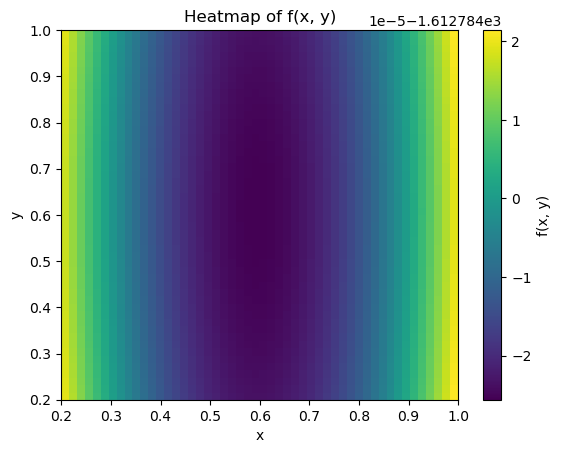

In [65]:
plt.imshow(predictive_mean.reshape(n_test_1d, n_test_1d), origin='lower', 
           extent=[u1_supp[0], u1_supp[1], u2_supp[0], u2_supp[1]], 
           cmap='viridis', aspect='auto')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(label='f(x, y)')
plt.title('Heatmap of f(x, y)')
plt.show()